In [1]:
import numpy as np
import pandas as pd
import math
import sqlite3
from sqlite3 import Error
import matplotlib.pyplot as plt
import seaborn as sns

Join the data from Part 1 with the data from Part 2 to create a new dataframe.

Load csv files to dataframe

In [2]:
yelp_df = pd.read_csv("yelp_df.csv")
foursquare_df = pd.read_csv("foursquare_df.csv")
station_df = pd.read_csv("station_df.csv")

Drop business id column in foursquare dataframe

In [3]:
foursquare_df = foursquare_df.drop('fsq_id',axis = 1)

Rename collumn to prepare for joining table

In [4]:
yelp_df.rename(columns = {'location.address1':'address'}, inplace = True)
foursquare_df.rename(columns = {'location.address':'address'}, inplace = True)

Join foursquare dataframe and yelp dataframe to get a new dataframe

In [5]:
join_df = pd.merge(yelp_df, foursquare_df, how="outer", on=["name", "address","station latitude","station longitude"])

#### Clean data from table

Create function to group two column in join_df dataframe into a new one. The new value is the mean of the two old one

In [6]:
def join_column(one,two,new,dataframe):
    dataframe[new] = pd.Series()
    for index in range(len(dataframe)):
        if math.isnan(dataframe[one][index]) and math.isnan(dataframe[two][index]): dataframe[new][index] = np.nan
        elif math.isnan(dataframe[one][index]) and ~math.isnan(dataframe[two][index]): dataframe[new][index] = dataframe[two][index]
        elif ~math.isnan(dataframe[one][index]) and math.isnan(dataframe[two][index]): dataframe[new][index] = dataframe[one][index]
        else: dataframe[new][index] = (dataframe[one][index] + dataframe[two][index])/2     
    dataframe.drop([one,two],axis=1,inplace=True)
    
    

Join two column with similar type to a new one 

In [7]:
join_column('rating_x','rating_y','rating',join_df)
join_column('station id_x','station id_y','station id',join_df)
join_column('price_x','price_y','price',join_df)
join_column('distance_x','distance_y','distance',join_df)
join_column('number of bikes_x','number of bikes_y','number of bikes',join_df)

C:\Users\bosst\AppData\Local\Temp\ipykernel_10660\2294137828.py:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  dataframe[new] = pd.Series()
C:\Users\bosst\AppData\Local\Temp\ipykernel_10660\2294137828.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  elif ~math.isnan(dataframe[one][index]) and math.isnan(dataframe[two][index]): dataframe[new][index] = dataframe[one][index]
C:\Users\bosst\AppData\Local\Temp\ipykernel_10660\2294137828.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  else: dataframe[

Create new id columns for each restaurants

In [8]:
join_df["restaurant id"] = join_df.index + 1
join_df["review_count"] = pd.to_numeric(
    join_df["review_count"], 
    errors='coerce'
).astype('Int64')
join_df["number of bikes"] = join_df["number of bikes"].astype(int)
join_df["station id"] = join_df["station id"].astype(int)

Provide a visualization that you used as part of your EDA process. Explain the initial pattern or relationship you discoved through this visualization. 

Create new analytics dataframe with stations information, the average rating of nearby restaurant, average rating, averrage review count, number of nearby restaurant,average distance to near by resturant

In [9]:
analytics_df = join_df[['station id','review_count','rating','price','distance','number of bikes']].groupby('station id').mean()
analytics_df['restaurant count'] = join_df[['restaurant id','station id']].groupby('station id').count()

In [10]:
analytics_df.head()

,review_count,rating,price,distance,number of bikes,restaurant count
station id,,,,,,
1,579.9,8.333929,1.807692,413.168044,0.0,28
2,73.95,7.414583,1.461538,922.595763,7.0,25
3,173.05,7.996552,1.916667,784.159093,8.0,29
4,357.3,8.171429,1.659091,528.041941,7.0,28
5,259.85,8.367857,1.833333,602.878624,11.0,28


Rename column

In [11]:
analytics_df = analytics_df.rename(columns={"review_count": "avg review count", "rating": "avg rating", "price": "avg price","distance":"avg distance"}, errors="raise")
analytics_df.head()

,avg review count,avg rating,avg price,avg distance,number of bikes,restaurant count
station id,,,,,,
1,579.9,8.333929,1.807692,413.168044,0.0,28
2,73.95,7.414583,1.461538,922.595763,7.0,25
3,173.05,7.996552,1.916667,784.159093,8.0,29
4,357.3,8.171429,1.659091,528.041941,7.0,28
5,259.85,8.367857,1.833333,602.878624,11.0,28


Export analytics dataframe to a csv file

In [23]:
analytics_df.to_csv("analytics_df.csv")

Scatter plot to see relationship between each data to the number of bikes

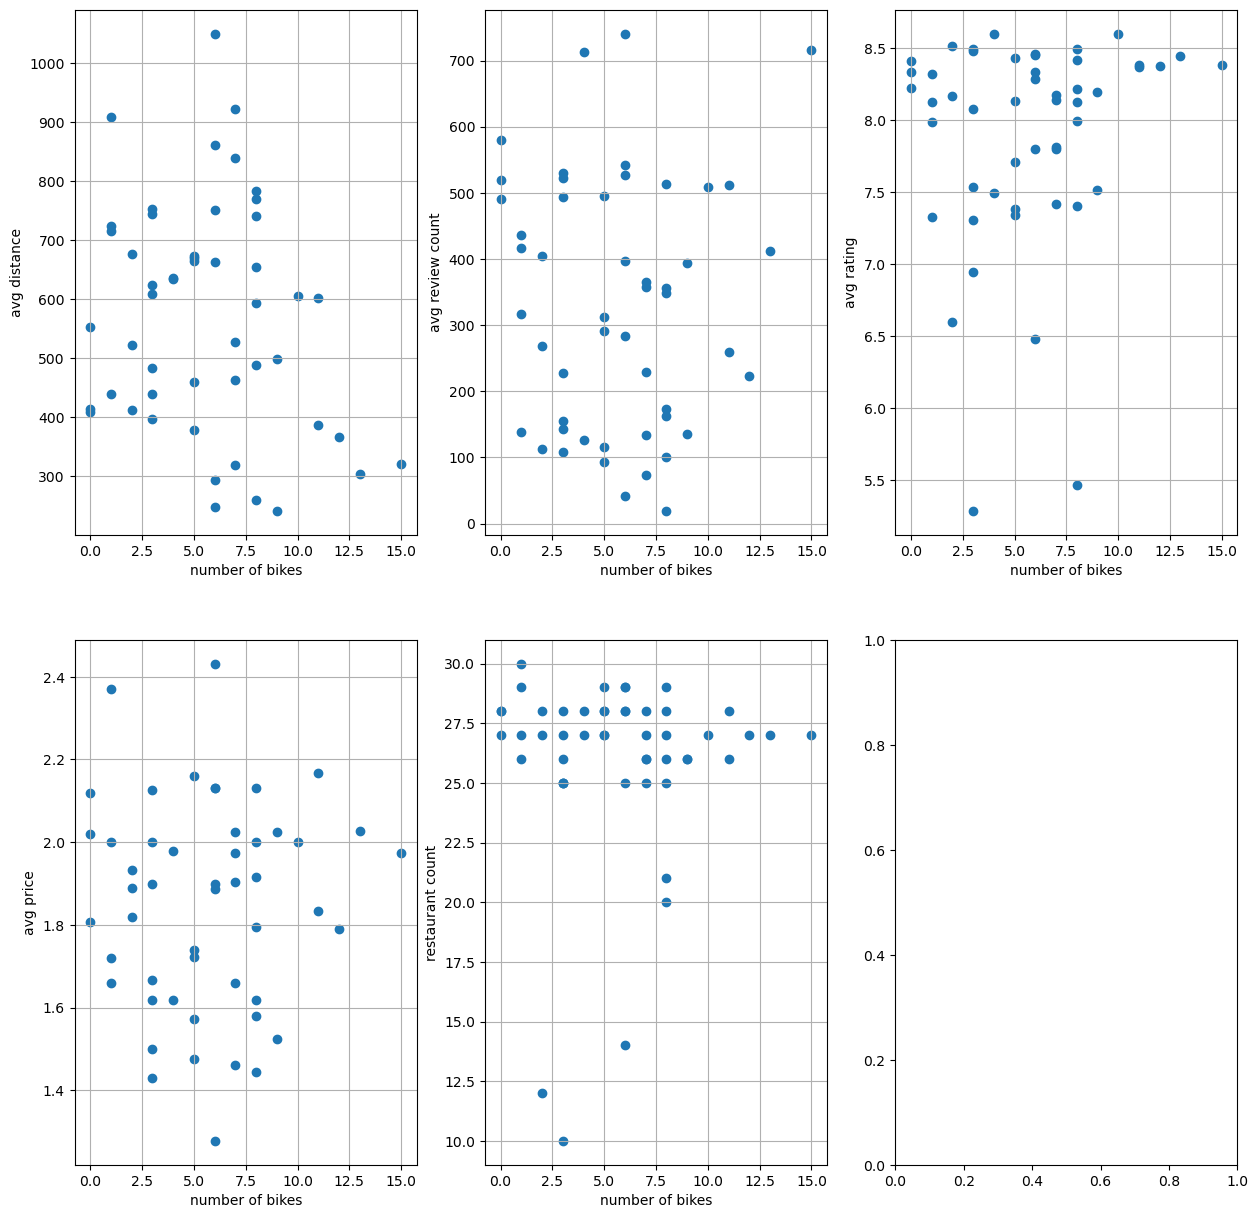

In [12]:
fig, axe = plt.subplots(nrows = 2, ncols = 3, figsize=(15,15))

axe[0,0].scatter(analytics_df['number of bikes'],analytics_df['avg distance'])
axe[0,0].set_xlabel('number of bikes')
axe[0,0].set_ylabel('avg distance')
axe[0,0].grid()

axe[0,1].scatter(analytics_df['number of bikes'],analytics_df['avg review count'])
axe[0,1].set_xlabel('number of bikes')
axe[0,1].set_ylabel('avg review count')
axe[0,1].grid()

axe[0,2].scatter(analytics_df['number of bikes'],analytics_df['avg rating'])
axe[0,2].set_xlabel('number of bikes')
axe[0,2].set_ylabel('avg rating')
axe[0,2].grid()

axe[1,0].scatter(analytics_df['number of bikes'],analytics_df['avg price'])
axe[1,0].set_xlabel('number of bikes')
axe[1,0].set_ylabel('avg price')
axe[1,0].grid()

axe[1,1].scatter(analytics_df['number of bikes'],analytics_df['restaurant count'])
axe[1,1].set_xlabel('number of bikes')
axe[1,1].set_ylabel('restaurant count')
axe[1,1].grid()

plt.show()

Heatmap to see correlation between each data

<Axes: >

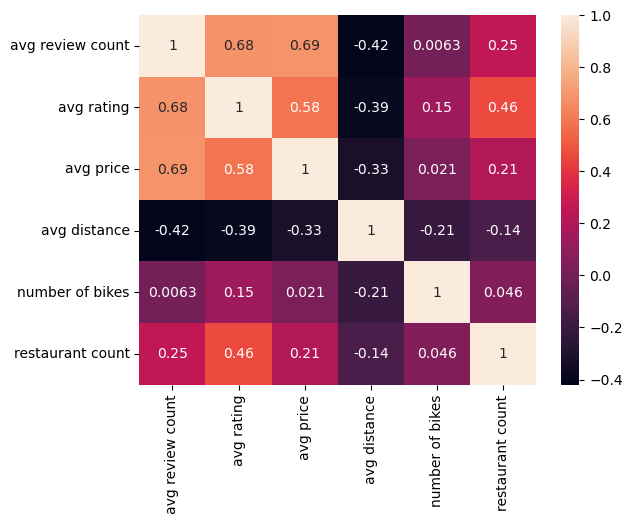

In [13]:
sns.heatmap(
    analytics_df.corr(),
    annot = True,
)

# Database

Put all your results in an SQLite3 database (remember, SQLite stores its databases as files in your local machine - make sure to create your database in your project's data/ directory!)

Function to create connection to database

In [14]:
def create_connection(path):
    connection = None
    try:
        connection = sqlite3.connect(path)
        print("Connection to SQLite DB successful")
    except Error as e:
        print(f"The error '{e}' occurred")
    return connection

Create and connect to restaurants database

In [15]:
connection = create_connection("restaurants.sqlite")

Connection to SQLite DB successful


Function to execute querry

In [16]:
def execute_query(connection, query):
    cursor = connection.cursor()
    try:
        cursor.execute(query)
        connection.commit()
        print("Query executed successfully")
    except Error as e:
        print(f"The error '{e}' occurred")

Create table querry

In [17]:
create_restaurant_location_table = """
CREATE TABLE IF NOT EXISTS restaurant_location (
  "restaurant id" INTEGER PRIMARY KEY,
  "address" TEXT,
  "distance" NUMERIC NOT NULL
);
"""
create_restaurant_info_table = """
CREATE TABLE IF NOT EXISTS restaurant_info (
  "restaurant id" INTEGER PRIMARY KEY,
  "station id" INTEGER NOT NULL,
  "name" TEXT,
  "price" NUMERIC,
  "review_count" INTEGER,
  "rating" NUMERIC
);
"""
create_station_table = """
CREATE TABLE IF NOT EXISTS station (
  "station id" INTEGER PRIMARY KEY,
  "station latitude" NUMERIC NOT NULL,
  "station longitude" NUMERIC NOT NULL,
  "number of bikes" INT NOT NULL
);
"""

Execute Create table querry

In [18]:
execute_query(connection, create_restaurant_location_table)
execute_query(connection, create_restaurant_info_table)
execute_query(connection, create_station_table)

Query executed successfully
Query executed successfully
Query executed successfully


Insert data from dataframe to sqlite database

In [19]:
join_df[["restaurant id","address","distance"]].to_sql("restaurant_location", connection,if_exists='replace',index=False)
join_df[["restaurant id","station id","name","price","review_count","rating"]].to_sql("restaurant_info", connection,if_exists='replace',index=False)
station_df[["station id","latitude","longitude","number of bikes"]].to_sql("station", connection,if_exists='replace',index=False)

737

Define read querry function

In [20]:
def execute_read_query(connection, query):
    cursor = connection.cursor()
    result = None
    try:
        cursor.execute(query)
        result = cursor.fetchall()
        return result
    except Error as e:
        print(f"The error '{e}' occurred")

Join table to validate data

In [21]:
select_users = """
SELECT ri."restaurant id",ri."name",ri."price",ri."review_count",ri."rating",rl."address",rl."distance",s."station id",s."latitude",s."longitude",s."number of bikes"
FROM restaurant_info AS ri
JOIN station AS s ON ri."station id" = s."station id"
JOIN restaurant_location AS rl ON rl."restaurant id" = ri."restaurant id"
LIMIT 10
"""

In [22]:
users = execute_read_query(connection, select_users)
for user in users:
    print(user)

(1, 'Mejana', 2.0, 812, 8.0, '2300 Wilson Blvd', 210.57419734291352, 1.0, 38.890612, -77.084801, 0.0)
(2, "Seamore's - Arlington", None, 155, 9.0, '2815 Clarendon Blvd', 670.7353272541926, 1.0, 38.890612, -77.084801, 0.0)
(3, 'Tupelo Honey Southern Kitchen & Bar', 2.0, 2391, 8.0, '1616 N Troy St', 308.05350854011704, 1.0, 38.890612, -77.084801, 0.0)
(4, 'Courthaus Social', 2.0, 480, 8.0, '2300 Clarendon Blvd', 199.4250353330203, 1.0, 38.890612, -77.084801, 0.0)
(5, 'Ambar', 3.0, 1878, 9.0, '2901 Wilson Blvd', 784.9736537020015, 1.0, 38.890612, -77.084801, 0.0)
(6, 'Green Pig Bistro', 2.0, 1109, 8.0, '1025 N Fillmore St', 845.4538266928838, 1.0, 38.890612, -77.084801, 0.0)
(7, 'Guerra Steakhouse', None, 88, 9.0, '1725 Wilson Blvd', 640.6712571053315, 1.0, 38.890612, -77.084801, 0.0)
(8, 'Brass Rabbit Pub', 2.0, 96, 9.0, '1210 N Garfield St', 885.4332557827812, 1.0, 38.890612, -77.084801, 0.0)
(9, 'Fire Works Pizza', 2.0, 865, 8.05, '2350 Clarendon Blvd', 230.52331013754133, 1.0, 38.8906